In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.models import load_model

2025-06-18 09:05:44.573273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750237544.770139      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750237544.826572      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_data_path = '/kaggle/input/facial-imagestv/Facial_Images/train'
validation_data_path = '/kaggle/input/facial-imagestv/Facial_Images/validation'

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Rescales pixel values from [0, 255] to [0, 1]
    rotation_range=30,            # Randomly rotates images in the range (degrees)
    shear_range=0.3,              # Shear angle in counter-clockwise direction in radians
    zoom_range=0.3,               # Random zoom within the range
    horizontal_flip=True,         # Randomly flip inputs horizontally
    fill_mode='nearest'          # Strategy used for filling in newly created pixel
)

validation_datagen = ImageDataGenerator(rescale=1./255)


In [5]:
train_generator = train_datagen.flow_from_directory(
    train_data_path,                # Path to training data directory
    color_mode='grayscale',       # Loads images as grayscale (1 channel)
    target_size=(48, 48),         # Resizes all images to 48x48 pixels
    batch_size=32,                # Number of images per batch
    class_mode='categorical',     # Returns one-hot encoded labels
    shuffle=True                  # Shuffles the data at each epoch
)

Found 28821 images belonging to 7 classes.


In [6]:
validation_generator = validation_datagen.flow_from_directory(
    validation_data_path,                # Path to training data directory
    color_mode='grayscale',       # Loads images as grayscale (1 channel)
    target_size=(48, 48),         # Resizes all images to 48x48 pixels
    batch_size=32,                # Number of images per batch
    class_mode='categorical',     # Returns one-hot encoded labels
    shuffle=True                  # Shuffles the data at each epoch
)

Found 7066 images belonging to 7 classes.


In [7]:
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [8]:
img, label = train_generator.__next__()

In [9]:
model = Sequential()

# Input Layer + Conv Block 1
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))

# Conv Block 2
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Conv Block 3
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))  # ⚠ Typo here: 'h128' should be '128'
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Conv Block 4
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Dense Layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))  # 7 output classes

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1750237569.466495      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [10]:
# Count number of training images
num_train_imgs = 0
for root, dirs, files in os.walk(train_data_path):
    num_train_imgs += len(files)

# Count number of test/validation images
num_test_imgs = 0
for root, dirs, files in os.walk(validation_data_path):
    num_test_imgs += len(files)

print(num_train_imgs)
print(num_test_imgs)

28821
7066


In [11]:
epochs = 30

history = model.fit(
    train_generator,
    steps_per_epoch=num_train_imgs // 32,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=num_test_imgs // 32
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1750237605.187671     107 service.cc:148] XLA service 0x790914010fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750237605.188416     107 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750237605.558447     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/900 ━━━━━━━━━━━━━━━━━━━━ 1:06 74ms/step - accuracy: 0.2431 - loss: 1.9432 

I0000 00:00:1750237609.601042     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


900/900 ━━━━━━━━━━━━━━━━━━━━ 164s 174ms/step - accuracy: 0.2507 - loss: 1.8025 - val_accuracy: 0.3447 - val_loss: 1.6535
Epoch 2/30
  1/900 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3750 - loss: 1.7046

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


900/900 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.3750 - loss: 1.7046 - val_accuracy: 0.3494 - val_loss: 1.6520
Epoch 3/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 59s 65ms/step - accuracy: 0.3258 - loss: 1.6886 - val_accuracy: 0.4222 - val_loss: 1.4962
Epoch 4/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.2500 - loss: 1.8652 - val_accuracy: 0.4227 - val_loss: 1.4981
Epoch 5/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 59s 65ms/step - accuracy: 0.3831 - loss: 1.5691 - val_accuracy: 0.4858 - val_loss: 1.3435
Epoch 6/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.3750 - loss: 1.5315 - val_accuracy: 0.4831 - val_loss: 1.3445
Epoch 7/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.4300 - loss: 1.4784 - val_accuracy: 0.5013 - val_loss: 1.3029
Epoch 8/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.3438 - loss: 1.5599 - val_accuracy: 0.5013 - val_loss: 1.3014
Epoch 9/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 60s 67ms/step - accuracy: 0.4575 - loss: 1.4061 - val_accuracy: 

In [12]:
model.save('model_file.h5')
model = tf.keras.models.load_model('model_file.h5')
faceDetect=cv2.CascadeClassifier('/kaggle/input/new-file/haarcascade_frontalface_default.xml')


In [13]:
labels_dict = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Neutral',
    5: 'Sad',
    6: 'Surprise'
}

In [14]:
frame=cv2.imread("/kaggle/input/test-7/angry.jpg")
gray=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [15]:
faces= faceDetect.detectMultiScale(gray, 1.3, 3)

In [16]:
for x,y,w,h in faces:
    sub_face_img=gray[y:y+h, x:x+w]
    resized=cv2.resize(sub_face_img, (48,48))
    normalize=resized/255.0
    reshaped=np.reshape(normalize, (1, 48, 48, 1))
    result=model.predict(reshaped)
    label=np.argmax(result, axis=1)[0]
    print(label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
0


In [17]:
cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255), 1)
cv2.rectangle(frame, (x,y), (x+w, y+h), (50,50,255), 2)
cv2.rectangle(frame, (x, y-40), (x+w, y), (50,50,255), -1)
cv2.putText(frame, labels_dict[label], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)

array([[[22,  2,  0],
        [22,  2,  0],
        [22,  2,  0],
        ...,
        [22,  1,  0],
        [22,  1,  0],
        [22,  1,  0]],

       [[25,  5,  0],
        [25,  5,  0],
        [25,  5,  0],
        ...,
        [22,  1,  0],
        [22,  1,  0],
        [22,  1,  0]],

       [[25,  5,  0],
        [25,  5,  0],
        [26,  6,  1],
        ...,
        [23,  2,  1],
        [23,  2,  1],
        [23,  2,  1]],

       ...,

       [[28,  9,  2],
        [28,  9,  2],
        [29, 10,  3],
        ...,
        [25,  5,  0],
        [25,  5,  0],
        [25,  5,  0]],

       [[28,  9,  2],
        [29, 10,  3],
        [30, 11,  4],
        ...,
        [26,  7,  0],
        [26,  7,  0],
        [26,  7,  0]],

       [[27,  8,  1],
        [28,  9,  2],
        [30, 11,  4],
        ...,
        [26,  7,  0],
        [26,  7,  0],
        [26,  7,  0]]], dtype=uint8)

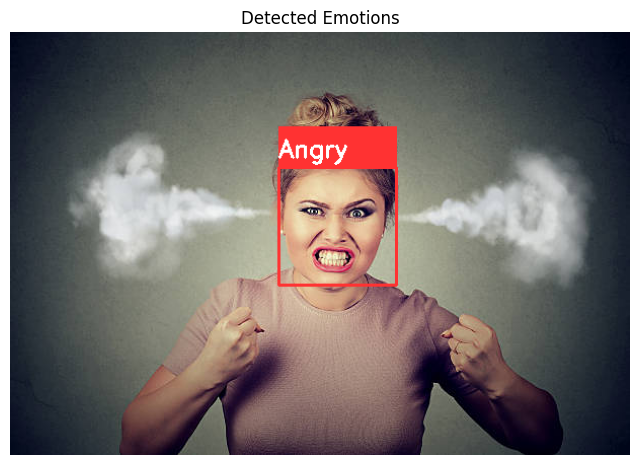

In [18]:
import matplotlib.pyplot as plt

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(frame_rgb)
plt.axis('off')
plt.title("Detected Emotions")
plt.show()
plt.show()